<a href="https://colab.research.google.com/github/aratinj/ovi_kaggle/blob/main/cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load data

In [95]:
!mkdir ~p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘~p’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [96]:
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
cat-dog-images-for-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [97]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Import library

In [98]:
import os
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling1D

In [99]:
import pandas as pd
df = pd.read_csv('/content/cat_dog.csv')

In [100]:
df.head(2)

,image,labels
0,dog.11289.jpg,1
1,cat.10836.jpg,0


In [ ]:
dir = '/content/cat_dog'

cat_dir = os.path.join(dir, 'cat')
dog_dir = os.path.join(dir, 'dog')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for file in os.listdir(dir):
  if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.bmp') or file.endswith('.jpeg') or file.endswith('.gif'):
   if 'cat' in file:
     shutil.move(os.path.join(dir, file), cat_dir)
   elif 'dog' in file:
     shutil.move(os.path.join(dir, file), dog_dir)

In [102]:
train = keras.utils.image_dataset_from_directory(directory = '/content/cat_dog',
                                        labels = 'inferred',
                                        label_mode = 'int',
                                        batch_size = 32,
                                        image_size = (256, 256),
                                        validation_split = 0.2,
                                        subset = 'training',
                                        seed=42
                                                )
val = keras.utils.image_dataset_from_directory(directory = '/content/cat_dog',
                                        labels = 'inferred',
                                        label_mode = 'int',
                                        batch_size = 32,
                                        image_size = (256, 256),
                                        validation_split = 0.2,
                                        subset = 'validation',
                                        seed=42
                                              )

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [103]:
def process(image, label):
   image = tf.cast(image / 255., tf.float32)
   return image, label

train = train.map(process)
val = val.map(process)

In [104]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding = 'valid',activation = 'relu', input_shape = (256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(64, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(128, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [106]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [107]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2)

In [108]:
model_history = model.fit(train,
                          epochs = 10,
                          validation_data = val,
                          callbacks = [early_stopping, lr_reduce])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 62s 89ms/step - accuracy: 0.5571 - loss: 3.0767 - val_accuracy: 0.6728 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.6804 - loss: 0.6054 - val_accuracy: 0.7058 - val_loss: 0.5903 - learning_rate: 0.0010
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.7172 - loss: 0.5644 - val_accuracy: 0.7790 - val_loss: 0.4795 - learning_rate: 0.0010
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.7795 - loss: 0.4612 - val_accuracy: 0.7746 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.8081 - loss: 0.4091 - val_accuracy: 0.7512 - val_loss: 0.5461 - learning_rate: 0.0010
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 93ms/step - accuracy: 0.8538 - loss: 0.3321 - val_accuracy: 0.8206 - val_loss: 0.4805 - learning_rate: 5.0000e-04


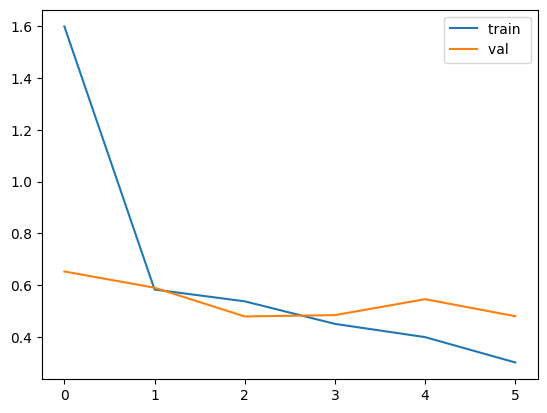

In [112]:
import matplotlib.pyplot as plt
plt.plot(model_history.history['loss'], label ='train ')
plt.plot(model_history.history['val_loss'], label ='val ')
plt.legend()

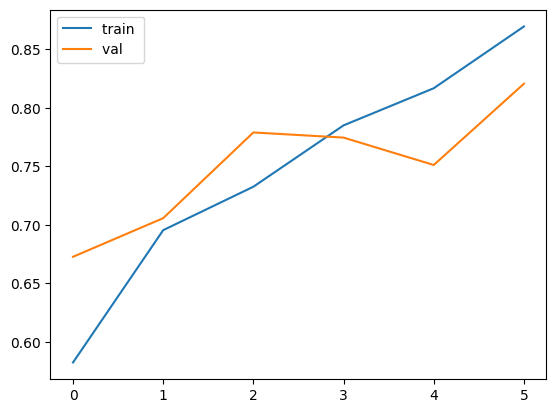

In [113]:
plt.plot(model_history.history['accuracy'], label ='train ')
plt.plot(model_history.history['val_accuracy'], label ='val ')
plt.legend()

Data Augmentation

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
datagen = ImageDataGenerator(
    rotation_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    rescale = 1. / 255 ,
    shear_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1. /255)

train = train_datagen.flow_from_directory(
    directory = '/content/cat_dog',
    target_size =  (150,150),
    batch_size = batch_size,
    class_mode = 'binary'
)

val = test_datagen.flow_from_directory(
    directory = '/content/cat_dog',
    target_size = (150, 150),
    batch_size = batch_size,
    class_mode = 'binary'
)


In [50]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), padding = 'valid',activation = 'relu', input_shape = (150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(64, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))


model.add(Conv2D(128, kernel_size = (3,3), padding = 'valid',activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), padding = 'valid', strides = 2))

model.add(Flatten())

model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'sigmoid'))

In [51]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [52]:
model_history = model.fit(
                train,
                epochs = 10,
                validation_data = val,
                callbacks =[early_stopping, lr_reduce])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 225s 274ms/step - accuracy: 0.5583 - loss: 1.1421 - val_accuracy: 0.7038 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 276s 301ms/step - accuracy: 0.6795 - loss: 0.5957 - val_accuracy: 0.6536 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 246s 280ms/step - accuracy: 0.7378 - loss: 0.5311 - val_accuracy: 0.7580 - val_loss: 0.5054 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 252s 267ms/step - accuracy: 0.7677 - loss: 0.4912 - val_accuracy: 0.7700 - val_loss: 0.4776 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 267s 273ms/step - accuracy: 0.7941 - loss: 0.4407 - val_accuracy: 0.8210 - val_loss: 0.3880 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 214s 272ms/step - accuracy: 0.8268 - loss: 0.3895 - val_accuracy: 0.8150 - val_loss: 0.4018 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 211s 268ms/step - accuracy: 0.8546 

In [54]:
test_loss, test_accuracy = model.evaluate(val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 91.55%


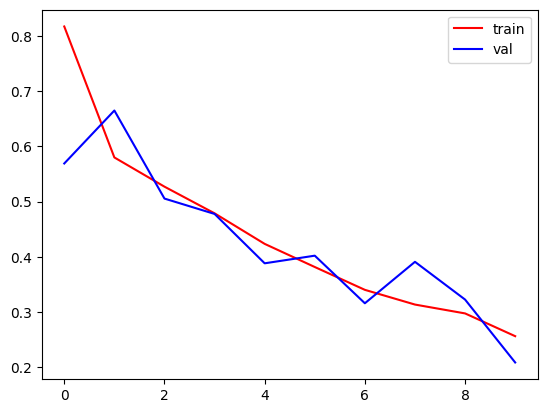

In [57]:
plt.plot(model_history.history['loss'],label = 'train', color ='red')
plt.plot(model_history.history['val_loss'], label = 'val', color='blue')
plt.legend()

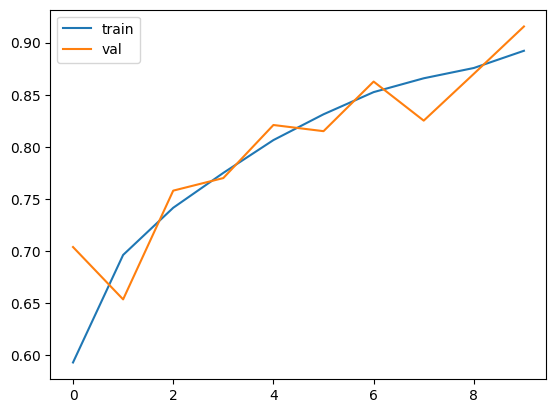

In [58]:
plt.plot(model_history.history['accuracy'],label = 'train')
plt.plot(model_history.history['val_accuracy'], label = 'val')
plt.legend()

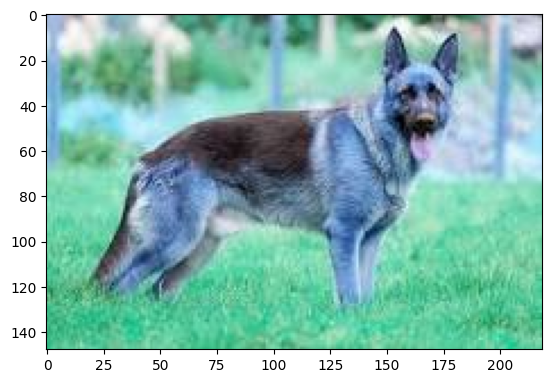

In [114]:
import cv2
test_image = cv2.imread('/content/dog.jpg')
plt.imshow(test_image)

In [115]:
test_image.shape

(148, 219, 3)

In [119]:
test_image = cv2.resize(test_image, (256, 256))

In [120]:
test_input = test_image.reshape((1, 256, 256, 3))

In [121]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step


array([[2.1642253e-26]], dtype=float32)

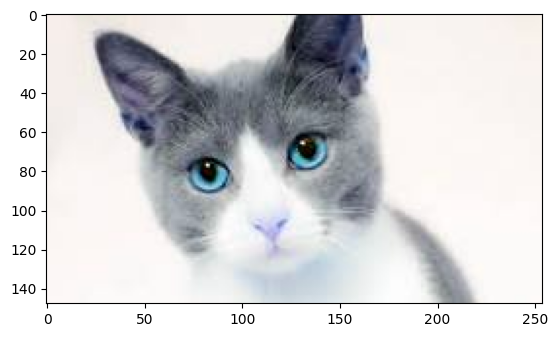

In [122]:
import cv2
cat_image = cv2.imread('/content/cat.jpg')
plt.imshow(cat_image)

In [123]:
cat_image.shape

(148, 254, 3)

In [124]:
cat_image = cv2.resize(cat_image, (256, 256))

In [125]:
cat_input = cat_image.reshape((1,256,256,3))

In [ ]:
model.predict(cat_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[0.41820097]], dtype=float32)

VGG16

In [90]:
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3)
)

In [64]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 18, 18, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 9, 9, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 16,812,353 (64.13 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
conv_base.trainable = False

batch_size = 32
train = keras.utils.image_dataset_from_directory(
    directory = '/content/cat_dog',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (150,150)
)
val = keras.utils.image_dataset_from_directory(
    directory = '/content/cat_dog',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (150,150)
)

Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [67]:
def process(image , label):
    image = tf.cast(image / 255. , tf.float32)
    return image , label
train = train.map(process)
val = val.map(process)

In [68]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [69]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, verbose = 1)
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-6, verbose = 1)

In [71]:
model_history = model.fit(train,
                          epochs = 10,
                          validation_data = val,
                          callbacks = [early_stopping, lr_reduce])

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 112s 143ms/step - accuracy: 0.9091 - loss: 0.2134 - val_accuracy: 0.9213 - val_loss: 0.1838 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 134ms/step - accuracy: 0.9254 - loss: 0.1765 - val_accuracy: 0.9267 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.9308 - loss: 0.1603 - val_accuracy: 0.9490 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 134ms/step - accuracy: 0.9452 - loss: 0.1342 - val_accuracy: 0.9513 - val_loss: 0.1170 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 173ms/step - accuracy: 0.9513 - loss: 0.1165 - val_accuracy: 0.9649 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 173ms/step - accuracy: 0.9651 - loss: 0.0904 - val_accuracy: 0.9672 - val_loss: 0.0811 - learning_rate: 0.0010
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 111s 134ms/step - accura

In [72]:
test_loss, test_accuracy = model.evaluate(val, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 97.36%


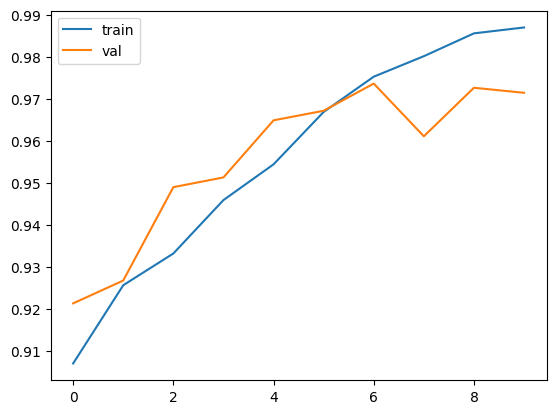

In [73]:
plt.plot(model_history.history['accuracy'], label = 'train')
plt.plot(model_history.history['val_accuracy'], label = 'val')
plt.legend()

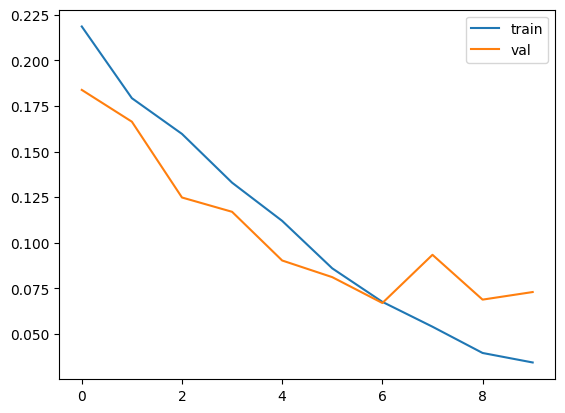

In [74]:
plt.plot(model_history.history['loss'], label = 'train')
plt.plot(model_history.history['val_loss'], label = 'val')
plt.legend()

Resnet50

In [79]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [87]:
model = ResNet50(weights = 'imagenet')

img_path = '/content/cat_dog/dog/dog.10.jpg'
img = image.load_img(img_path, target_size = (224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

In [88]:
pred = model.predict(x)
predicted = decode_predictions(pred, top = 3)[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [89]:
predicted

[('n02089867', 'Walker_hound', 0.61415905),
 ('n02088238', 'basset', 0.17390238),
 ('n02088632', 'bluetick', 0.09196651)]